# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

**Цель:** построить модель, которая по фотографии определит приблизительный возраст человека.

**Условие от заказчика:** значение метрики *MAE* должно быть *меньше 8*.

В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
sns.set_style('whitegrid')
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_rows', 40)

In [4]:
ages = pd.read_csv('/datasets/faces/labels.csv')

In [5]:
ages.head(3)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80


In [6]:
ages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [9]:
all_datagen = ImageDataGenerator(rescale=1./255)

all_gen_flow = all_datagen.flow_from_dataframe(dataframe=ages,
                                               directory='/datasets/faces/final_files/',
                                               x_col='file_name',
                                               y_col='real_age',
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='raw',
                                               seed=24
                                               ) 

Found 7591 validated image filenames.


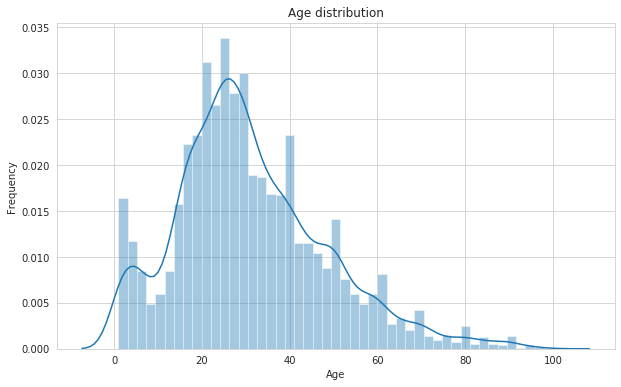

In [8]:
plt.figure(figsize=(10,6))
sns.distplot(ages['real_age'])
plt.title('Age distribution')
plt.ylabel('Frequency')
plt.xlabel('Age')
plt.show()

- В целом, данные практически нормально распределены, заметно смещение основного пика в сторону меньшего возраста в районе 25-30 лет, при этом виден небольшой пик в околонулевом интервале до 10 лет - вероятно это связано с тем, что в целом женщины чаще посещают продуктовые магазины и очень часто берут с собой детей, особенно маленьких. К тому же, 25-30 лет - наиболее популярный период для молодых семей, чтобы завести первого ребенка.
- Распределение целевого признака выглядит адекватно.

In [10]:
X, y = next(all_gen_flow)

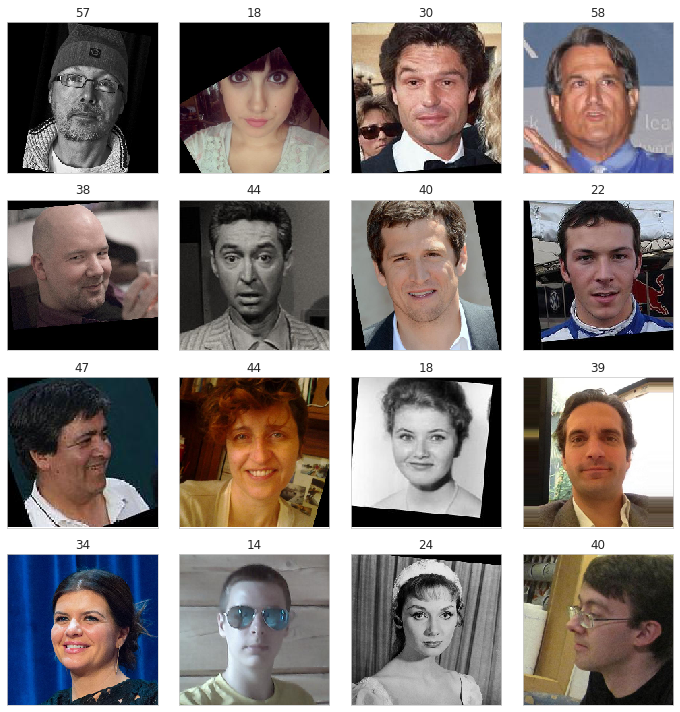

In [11]:
fig = plt.figure(figsize=(10,10))

for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(X[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(y[i])
    plt.tight_layout()

## Обучение модели

- Воспользуемся моделью ResNet50.
- Изменим лишь последние два слоя модели: добавим слой глобального пуллинга и полносвязный слой с одним нейроном и relu активацией
- Из аугментаций добавим горизонтальный флип

```python

from tensorflow.keras.layers import Dense, Flatten, AvgPool2D, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

import pandas as pd
import numpy as np



def load_train(path):
    train_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.25, horizontal_flip=True)
    ages = pd.read_csv(path+'/labels.csv')

    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=ages,
                                                           directory=path+'/final_files',
                                                           x_col='file_name',
                                                           y_col='real_age',
                                                           target_size=(224, 224),
                                                           batch_size=32,
                                                           class_mode='raw',
                                                           subset='training',
                                                           seed=24
                                                           )

    return train_datagen_flow



def load_test(path):
    test_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.25)
    ages = pd.read_csv(path+'/labels.csv')

    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=ages,
                                                         directory=path+'/final_files',
                                                         x_col='file_name',
                                                         y_col='real_age',
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         class_mode='raw',
                                                         subset='validation',
                                                         seed=24
                                                         )

    return test_datagen_flow



def create_model(input_shape):
    backbone = ResNet50(input_shape=(224, 224, 3),
                        weights='imagenet',
                        include_top=False
                        )
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))

    optimizer = Adam(lr=0.0007)
    model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae'])

    return model



def train_model(model, train_data, test_data, batch_size=None, epochs=25, steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/25
178/178 - 94s - loss: 11.5528 - mae: 11.5539 - val_loss: 49.2391 - val_mae: 49.0747
Epoch 2/25
178/178 - 37s - loss: 9.1638 - mae: 9.1643 - val_loss: 15.7484 - val_mae: 15.8553
Epoch 3/25
178/178 - 38s - loss: 8.6117 - mae: 8.6123 - val_loss: 29.4391 - val_mae: 29.6048
Epoch 4/25
178/178 - 37s - loss: 7.9241 - mae: 7.9247 - val_loss: 12.6063 - val_mae: 12.6427
Epoch 5/25
178/178 - 37s - loss: 7.6593 - mae: 7.6601 - val_loss: 9.9248 - val_mae: 9.9481
Epoch 6/25
178/178 - 37s - loss: 7.1077 - mae: 7.1087 - val_loss: 9.2534 - val_mae: 9.3001
Epoch 7/25
178/178 - 37s - loss: 6.7139 - mae: 6.7142 - val_loss: 10.4364 - val_mae: 10.4760
Epoch 8/25
178/178 - 37s - loss: 6.4660 - mae: 6.4665 - val_loss: 7.9545 - val_mae: 7.9781
Epoch 9/25
178/178 - 37s - loss: 6.1274 - mae: 6.1282 - val_loss: 10.3235 - val_mae: 10.2858
Epoch 10/25
178/178 - 38s - loss: 5.9587 - mae: 5.9589 - val_loss: 8.4056 - val_mae: 8.4239
Epoch 11/25
178/178 - 37s - loss: 5.6989 - mae: 5.6995 - val_loss: 7.8495 - val_mae: 7.8923
Epoch 12/25
178/178 - 37s - loss: 5.3540 - mae: 5.3544 - val_loss: 7.8767 - val_mae: 7.9030
Epoch 13/25
178/178 - 38s - loss: 5.3557 - mae: 5.3561 - val_loss: 8.2363 - val_mae: 8.2347
Epoch 14/25
178/178 - 38s - loss: 4.9954 - mae: 4.9956 - val_loss: 7.9150 - val_mae: 7.9352
Epoch 15/25
178/178 - 37s - loss: 4.8363 - mae: 4.8365 - val_loss: 8.1391 - val_mae: 8.1219
Epoch 16/25
178/178 - 38s - loss: 4.6463 - mae: 4.6466 - val_loss: 8.1147 - val_mae: 8.1378
Epoch 17/25
178/178 - 38s - loss: 4.5355 - mae: 4.5356 - val_loss: 7.6697 - val_mae: 7.6871
Epoch 18/25
178/178 - 37s - loss: 4.3456 - mae: 4.3455 - val_loss: 8.5339 - val_mae: 8.5305
Epoch 19/25
178/178 - 37s - loss: 4.1021 - mae: 4.1022 - val_loss: 7.5633 - val_mae: 7.5640
Epoch 20/25
178/178 - 37s - loss: 3.8924 - mae: 3.8927 - val_loss: 6.7392 - val_mae: 6.7337
Epoch 21/25
178/178 - 37s - loss: 3.8353 - mae: 3.8356 - val_loss: 7.4752 - val_mae: 7.4925
Epoch 22/25
178/178 - 37s - loss: 3.7515 - mae: 3.7518 - val_loss: 6.8102 - val_mae: 6.7847
Epoch 23/25
178/178 - 39s - loss: 3.6502 - mae: 3.6502 - val_loss: 7.3075 - val_mae: 7.3203
Epoch 24/25
178/178 - 39s - loss: 3.5547 - mae: 3.5547 - val_loss: 8.3680 - val_mae: 8.3762
Epoch 25/25
178/178 - 39s - loss: 3.4534 - mae: 3.4535 - val_loss: 7.4609 - val_mae: 7.4798

```

## Анализ обученной модели

- Уже на 13 эпохе модель показала требуемый результат
- Возможно 20 эпох - слишком много, модель переобучается, т.к. значение метрики по тестовой выборки сильно отличается от такого по обучающей.
- Для того, чтобы убрать переобучение возможно стоит использовать меньше слоев, либо уменьшить значения параметра learning rate для оптимизации обучения